In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats

In [2]:
def merge_fleet_avl(fleet_data_path, avl_data_path):
    avl_data = pd.read_csv(avl_data_path)
    fleet_data = pd.read_excel(fleet_data_path)
    avl_data.columns = ['IMEI Unit', 'start_time', 'stop_time', 'distance_travelled', 'moving_time', 'idle_time', 'speed']
    merge_df = pd.merge(avl_data, fleet_data, on='IMEI Unit', how='inner')
    merge_df = merge_df.drop(merge_df.iloc[:, -2:].columns, axis=1)
    
    return merge_df


def calculate_service_year(df):
    vehicle_ids = df['IMEI Unit'].unique()
    for id in vehicle_ids:
        start_year = df.loc[df['IMEI Unit'] == id, 'start_time'].min()
        start_year = int(str(start_year)[:4])
        stop_year = df.loc[df['IMEI Unit'] == id, 'stop_time'].max()
        stop_year = int(str(stop_year)[:4])
        df.loc[df['IMEI Unit'] == id, 'start_year'] = start_year
        df.loc[df['IMEI Unit'] == id, 'stop_year'] = stop_year

        if stop_year < 2025:            
            service_year = stop_year - start_year                      
            df.loc[df['IMEI Unit'] == id, 'service_year'] = service_year
        else:  # if stop year is 2025, the vehicle is still in service, we assume service-year of this vehicle is 0 for now
            df.loc[df['IMEI Unit'] == id, 'service_year'] = 0   

    return df

In [ ]:
avl_data_path = '../data/RND.csv'
fleet_data_path = '../Aramco Leased Vehicles - from 2012 up-to-date.xlsx'
avl_data = pd.read_csv(avl_data_path)
fleet_data = pd.read_excel(fleet_data_path)
fleet_data['IMEI Unit'] = fleet_data['IMEI Unit'].astype(str)
avl_data.columns = ['IMEI Unit', 'start_time', 'stop_time', 'distance_travelled', 'moving_time', 'idle_time', 'speed']
print(len(avl_data['IMEI Unit'].unique()), len(fleet_data['IMEI Unit'].unique()))

/var/folders/rh/5tkty3715h119sm4y35zw4dr0000gn/T/ipykernel_62116/3032701236.py:3: DtypeWarning: Columns (0) have mixed types. Specify dtype option on import or set low_memory=False.
  avl_data = pd.read_csv(avl_data_path)


24875 11254


0

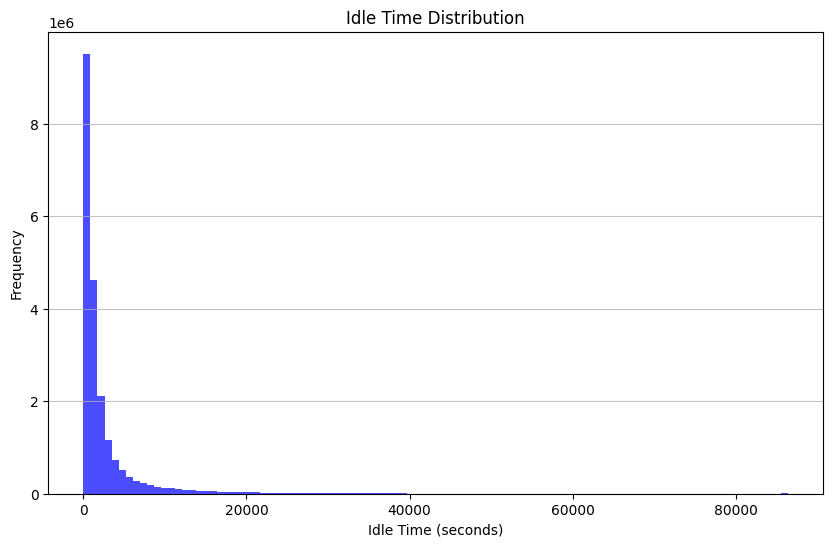

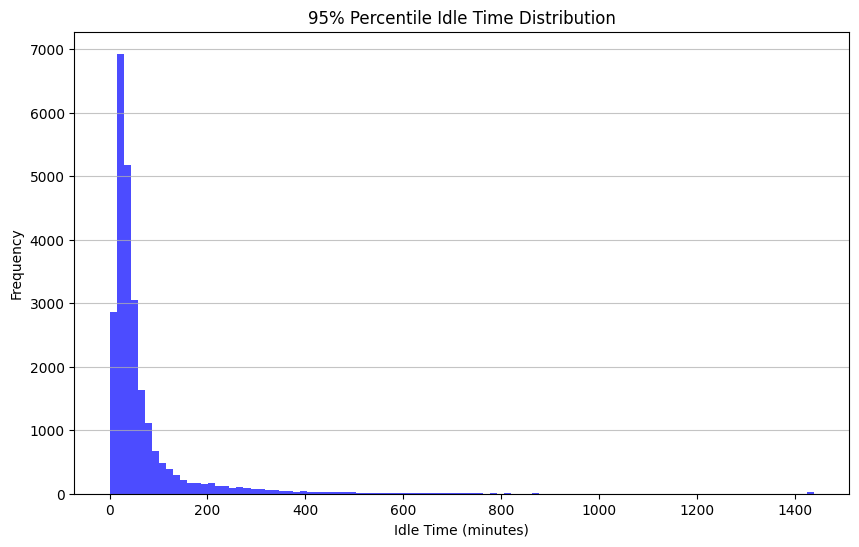

In [12]:
# Plot idlt time distribution
plt.figure(figsize=(10, 6))
plt.hist(avl_data['idle_time'], bins=100, color='blue', alpha=0.7)
plt.title('Idle Time Distribution')
plt.xlabel('Idle Time (seconds)')
plt.ylabel('Frequency')
plt.grid(axis='y', alpha=0.75)


# Plot 95% percentile idle time of each vehicle
perct_idle_95 = avl_data.groupby('IMEI Unit')['idle_time'].quantile(0.85).reset_index()
perct_idle_95['idle_time'] = perct_idle_95['idle_time']/60
plt.figure(figsize=(10, 6))
plt.hist(perct_idle_95['idle_time'], bins=100, color='blue', alpha=0.7)
plt.title('95% Percentile Idle Time Distribution')
plt.xlabel('Idle Time (minutes)')
plt.ylabel('Frequency')
plt.grid(axis='y', alpha=0.75)

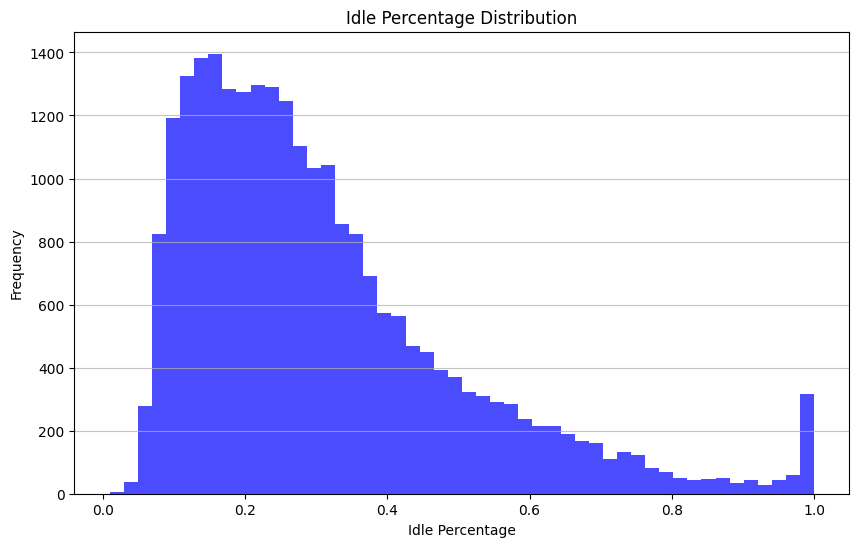

In [19]:
# plot idle perct distribution (each vehicle has one idle perct)
idle_sum = avl_data.groupby('IMEI Unit')['idle_time'].sum()
moving_sum = avl_data.groupby('IMEI Unit')['moving_time'].sum()
idle_perct = (idle_sum / (idle_sum + moving_sum)).reset_index()
idle_perct.columns = ['IMEI Unit', 'idle_perct']

plt.figure(figsize=(10, 6))
plt.hist(idle_perct['idle_perct'], bins=50, color='blue', alpha=0.7)
plt.title('Idle Percentage Distribution')
plt.xlabel('Idle Percentage')
plt.ylabel('Frequency')
plt.grid(axis='y', alpha=0.75)


# # Plot idle_perct by trip
# avl_data['total_time'] = avl_data['moving_time'] + avl_data['idle_time']
# avl_data = avl_data[avl_data['total_time'] != 0]
# avl_data['idle_perct'] = avl_data['idle_time'] / avl_data['total_time']
# plt.figure(figsize=(10, 6)) 
# plt.hist(avl_data['idle_perct'], bins=50, color='blue', alpha=0.7)
# plt.title('Idle Percentage Distribution by Trip')
# plt.xlabel('Idle Percentage')
# plt.ylabel('Frequency')
# plt.grid(axis='y', alpha=0.75)

In [13]:
merge_df = merge_fleet_avl(fleet_data_path, avl_data_path)
merge_df.head()

/var/folders/rh/5tkty3715h119sm4y35zw4dr0000gn/T/ipykernel_57984/1208836461.py:2: DtypeWarning: Columns (0) have mixed types. Specify dtype option on import or set low_memory=False.
  avl_data = pd.read_csv(avl_data_path)


,IMEI Unit,start_time,stop_time,distance_travelled,moving_time,idle_time,speed,Pri. Stat.,Vehicle Door No,Make,Model,Model Year,Activity Type,Activity Type Description,Actual Retired Date,Fuel Type
0,354725060308701,20141218160701,20141218165301,31.73,1465,935,96,TRP,RT3404,Chevy,Silverado,2014,TL025,Pickup 4x2 1/2 Ton,NaN,Gasoline
1,354725060308701,20141221052118,20141221164320,69.54,3470,1346,111,TRP,RT3404,Chevy,Silverado,2014,TL025,Pickup 4x2 1/2 Ton,NaN,Gasoline
2,354725060308701,20141222051716,20141222164606,61.85,4068,1161,111,TRP,RT3404,Chevy,Silverado,2014,TL025,Pickup 4x2 1/2 Ton,NaN,Gasoline
3,354725060308701,20141223051720,20141223163704,62.67,3528,398,111,TRP,RT3404,Chevy,Silverado,2014,TL025,Pickup 4x2 1/2 Ton,NaN,Gasoline
4,354725060308701,20141224051843,20141224163713,82.17,4760,1222,111,TRP,RT3404,Chevy,Silverado,2014,TL025,Pickup 4x2 1/2 Ton,NaN,Gasoline


In [14]:
merge_df.shape

(527522, 16)

In [10]:
df = calculate_service_year(merge_df)
df.head()

,IMEI Unit,start_time,stop_time,distance_travelled,moving_time,idle_time,speed,Pri. Stat.,Vehicle Door No,Make,Model,Model Year,Activity Type,Activity Type Description,Actual Retired Date,Fuel Type,start_year,stop_year,service_year
0,354725060308701,20141218160701,20141218165301,31.73,1465,935,96,TRP,RT3404,Chevy,Silverado,2014,TL025,Pickup 4x2 1/2 Ton,NaN,Gasoline,2014.0,2025.0,0.0
1,354725060308701,20141221052118,20141221164320,69.54,3470,1346,111,TRP,RT3404,Chevy,Silverado,2014,TL025,Pickup 4x2 1/2 Ton,NaN,Gasoline,2014.0,2025.0,0.0
2,354725060308701,20141222051716,20141222164606,61.85,4068,1161,111,TRP,RT3404,Chevy,Silverado,2014,TL025,Pickup 4x2 1/2 Ton,NaN,Gasoline,2014.0,2025.0,0.0
3,354725060308701,20141223051720,20141223163704,62.67,3528,398,111,TRP,RT3404,Chevy,Silverado,2014,TL025,Pickup 4x2 1/2 Ton,NaN,Gasoline,2014.0,2025.0,0.0
4,354725060308701,20141224051843,20141224163713,82.17,4760,1222,111,TRP,RT3404,Chevy,Silverado,2014,TL025,Pickup 4x2 1/2 Ton,NaN,Gasoline,2014.0,2025.0,0.0


In [11]:
vehicle_2013 = df[df['Model Year'] == 2013]['IMEI Unit'].unique()
start_year_2013 = [df[df['IMEI Unit'] == id]['start_year'].min() for id in vehicle_2013]
print(min(start_year_2013), max(start_year_2013))

2024.0 2024.0


[[10, np.int64(2014)], [4, np.int64(2015)], [329, np.int64(2022)], [57, np.int64(2021)], [654, np.int64(2023)], [9, np.int64(2020)], [16, np.int64(2018)], [25, np.int64(2019)], [50, np.int64(2013)], [4171, np.int64(2024)]]


Text(0.5, 1.0, 'Number of Vehicles per Model Year')

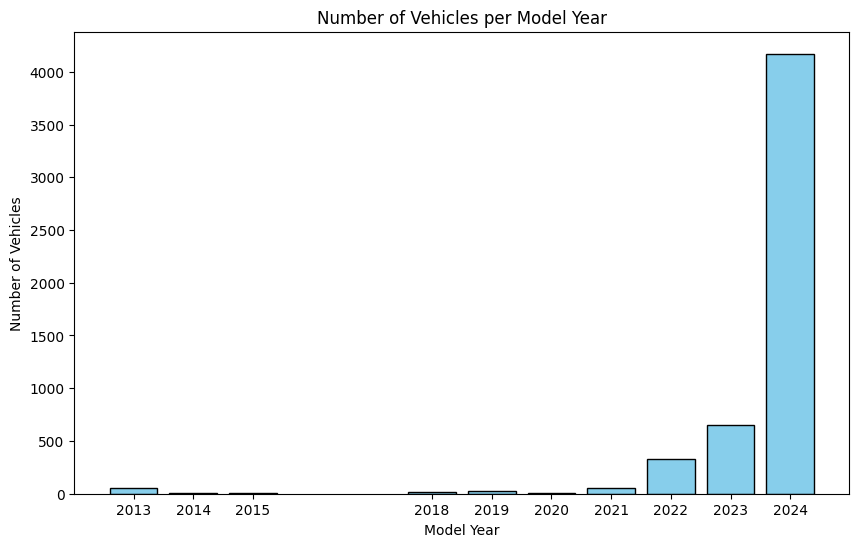

In [12]:
model_years = merge_df['Model Year'].unique()
num_vehicle_per_model_year = [[merge_df[merge_df['Model Year'] == year]['IMEI Unit'].nunique(), year] for year in model_years]
print(num_vehicle_per_model_year)
sum([arr[0] for arr in num_vehicle_per_model_year])

# Visualization
plt.figure(figsize=(10, 6))
x_values = [arr[1] for arr in num_vehicle_per_model_year]  # First elements for x-axis
y_values = [arr[0] for arr in num_vehicle_per_model_year]  # Second elements for y-axis
plt.bar(x_values, y_values, color='skyblue', edgecolor='black')
plt.xticks(x_values)
plt.xlabel('Model Year')
plt.ylabel('Number of Vehicles')
plt.title('Number of Vehicles per Model Year')



([<matplotlib.axis.XTick at 0x116c65180>,
 [Text(2014.0, 0, '2014'), Text(2024.0, 0, '2024'), Text(2025.0, 0, '2025')])

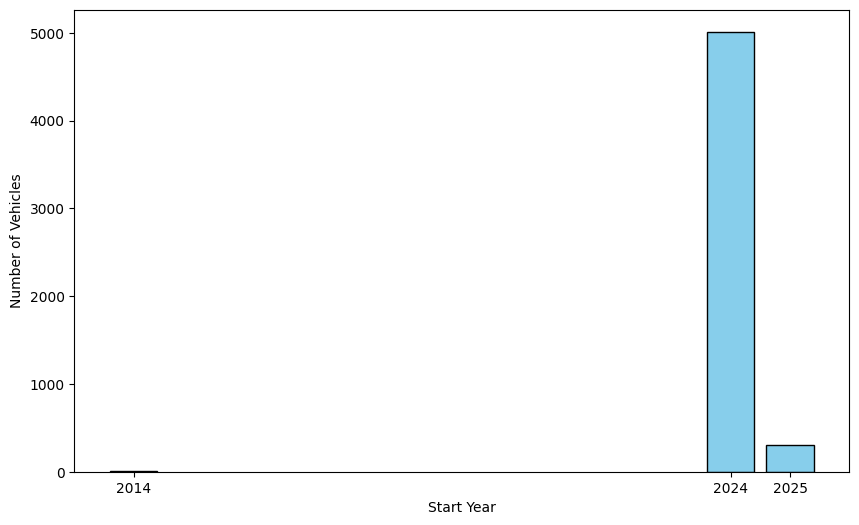

In [14]:
num_vehicle_per_start_year = df.groupby('start_year')['IMEI Unit'].nunique()
plt.figure(figsize=(10, 6))
plt.bar(num_vehicle_per_start_year.index, num_vehicle_per_start_year.values, color='skyblue', edgecolor='black')
plt.xlabel('Start Year')        
plt.ylabel('Number of Vehicles')
plt.xticks(num_vehicle_per_start_year.index)

([<matplotlib.axis.XTick at 0x116cb7970>,
 [Text(2024.0, 0, '2024'), Text(2025.0, 0, '2025')])

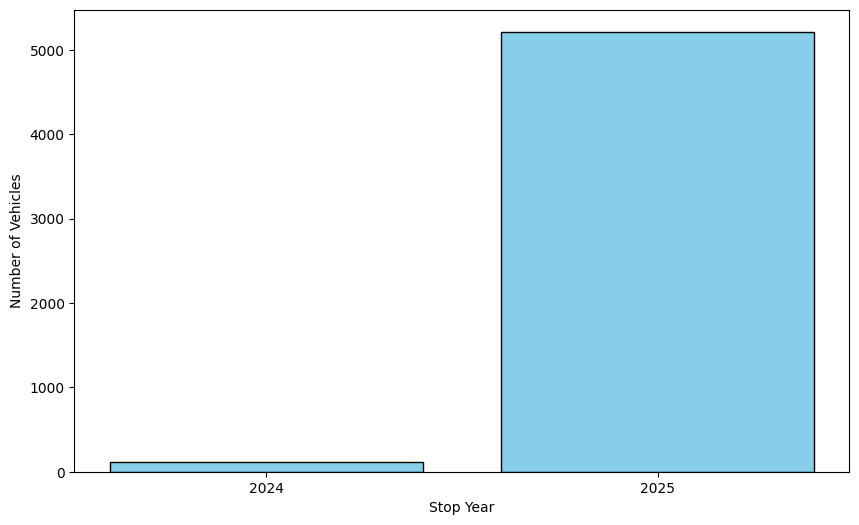

In [15]:
num_vehicle_per_start_year = df.groupby('stop_year')['IMEI Unit'].nunique()
plt.figure(figsize=(10, 6))
plt.bar(num_vehicle_per_start_year.index, num_vehicle_per_start_year.values, color='skyblue', edgecolor='black')
plt.xlabel('Stop Year')        
plt.ylabel('Number of Vehicles')
plt.xticks(num_vehicle_per_start_year.index)

In [8]:
# plot start year distribution for all vehicles
avl_df = pd.read_csv('../RND.csv')
avl_df.columns = ['IMEI Unit', 'start_time', 'stop_time', 'distance_travelled', 'moving_time', 'idle_time', 'speed']
ids = avl_df['IMEI Unit'].unique()
avl_df.head()


/var/folders/rh/5tkty3715h119sm4y35zw4dr0000gn/T/ipykernel_95684/3818871351.py:2: DtypeWarning: Columns (0) have mixed types. Specify dtype option on import or set low_memory=False.
  avl_df = pd.read_csv('../RND.csv')


,IMEI Unit,start_time,stop_time,distance_travelled,moving_time,idle_time,speed
0,355200040542414,20130721052048,20130721124940,105.0,4999,418,104
1,355200040542414,20130722051631,20130722115322,218.0,10550,514,106
2,355200040542414,20130723060459,20130723122704,105.0,5181,747,104
3,355200040542414,20130724055705,20130724132215,184.0,8613,412,106
4,355200040542414,20130725050633,20130725140301,140.0,6031,102,120


In [17]:
avl_df['start_year'] = avl_df['start_time'].apply(lambda x: int(str(x)[:4]))
vehicle_year = avl_df.groupby('IMEI Unit')['start_year'].min()

In [23]:
vehicle_year_df = pd.DataFrame(vehicle_year)
vehicle_year_df = vehicle_year_df.reset_index()
vehicle_year_df.head()


,IMEI Unit,start_year
0,352739090070571,2024
1,352739092194015,2024
2,352739092202115,2024
3,352739092204095,2024
4,352739092240982,2024


([<matplotlib.axis.XTick at 0x14a918dc0>,
 [Text(2013, 0, '2013'),
  Text(2014, 0, '2014'),
  Text(2015, 0, '2015'),
  Text(2016, 0, '2016'),
  Text(2017, 0, '2017'),
  Text(2018, 0, '2018'),
  Text(2019, 0, '2019'),
  Text(2020, 0, '2020'),
  Text(2021, 0, '2021'),
  Text(2022, 0, '2022'),
  Text(2023, 0, '2023'),
  Text(2024, 0, '2024'),
  Text(2025, 0, '2025')])

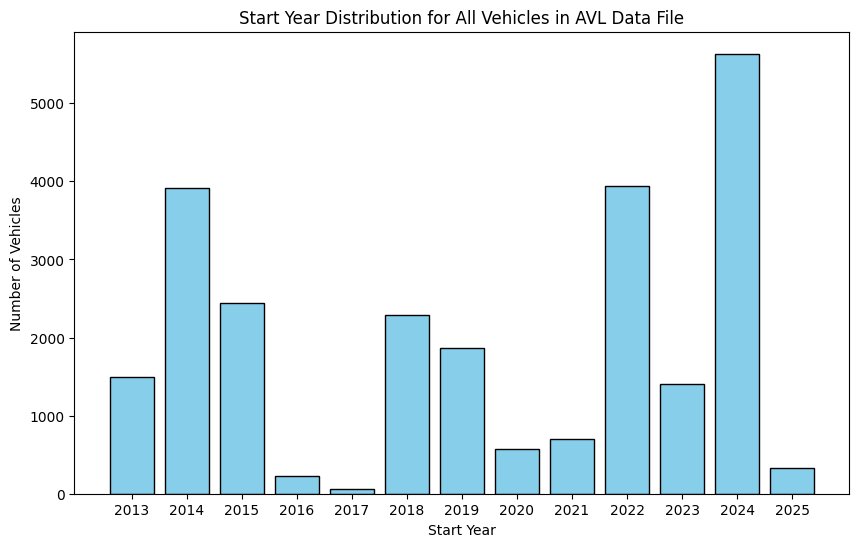

In [26]:
num_vehicle_per_start_year = vehicle_year_df.groupby('start_year')['IMEI Unit'].nunique()
plt.figure(figsize=(10, 6))
plt.bar(num_vehicle_per_start_year.index, num_vehicle_per_start_year.values, color='skyblue', edgecolor='black')        
plt.xlabel('Start Year')
plt.ylabel('Number of Vehicles')
plt.title('Start Year Distribution for All Vehicles in AVL Data File')
plt.xticks(num_vehicle_per_start_year.index)